<a href="https://colab.research.google.com/github/tingyiwu714/san-diego-crime-analysis/blob/master/Spark_SD_Crime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# San Diego Crime Analysis

An analysis of crimes in San Diego County from 2007 to 2017 using Apache Spark.

## Contents

1. Data Cleaning
2. Data Visualization
2. Geospatial Visualization
3. Conclusion



## 0: Setup and Load Data

### 0.1 Set up Google Drive environment

In [ ]:
# Install Spark, Java and findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-bin-hadoop3.2.tgz
!pip install -q findspark

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# Initilize pyspark
import findspark
findspark.init()

# Start spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# Install geocoding library 
!pip install geopy

# Install folium
!pip install folium

In [231]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import functions
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import Row
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import *
import matplotlib.patches as mpatches
import calendar

from geopy.geocoders import Nominatim

import folium
from folium.plugins import HeatMap, MarkerCluster
from folium import plugins

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Connect Google Colab with Google Drive
from google.colab import drive
drive.mount('/drive')

### 0.2 Load datasets into Spark DataFrames

The data includes all valid crimes reported to the San Diego County Police Departments from 2007 to 2017. It was adapted from the San Diego Regional Data Library. 

The data is separated in years and in different formats.
*   Datasets of 2007 to 2011 are in csv format ([link](https://data.sandiegodata.org/dataset/raw-san-diego-county-crime-incidents-2007-2013/))
*   Datasets of 2012 to 2017 are in xlsx format  ([link](https://data.sandiegodata.org/dataset/raw-san-diego-county-crime-incidents-2012-2017/))

The data has been saved in Google Drive, and will be loaded in Spark DataFrames from there.

In [7]:
# Load crime data between 2007 to 2011
file_id = ['16GBta4t4zAWO0yr7w7dLDyo7Ji34zzWf',
           '1EblPEoGj4x8hvxLzjsDZh-IKeYhELE18',
           '1tbURDD5QDeAgaHgGvZxIBIrkmQIxFPeh',
           '1WuFB52qSr-dnB5--u5jYwog5Uno12tEK',
           '1QdadT4p1O-FJdjfFlSkSI2Y9dFN-cKdq']
mySchema = StructType([StructField("activityType", StringType(), True),
                       StructField("AGENCY", StringType(), True),
                       StructField("activityDate", StringType(), True),
                       StructField("LEGEND", StringType(), True),
                       StructField("Charge_Description", StringType(), True),
                       StructField("BLOCK_ADDRESS", StringType(), True),
                       StructField("City_Name", StringType(), True),
                       StructField("ZipCode", StringType(), True)])
sdfs = []
for id in file_id:
  link = 'https://drive.google.com/uc?export=download&id={FILE_ID}'
  url = link.format(FILE_ID=id)
  pdf = pd.read_csv(url, dtype=str)
  spd = spark.createDataFrame(pdf, schema=mySchema)
  sdfs.append(spd)
df_07to11 = reduce(DataFrame.unionAll, sdfs)

In [8]:
# Load crime data between 2012 to 2017
file_id = ['1TpeuhgB7IHa7IDupjkSoY_CdLHQCdIhd',
           '1WgMUozlgojzrc3RPREimLrcToY1yoRaA',
           '1d05-6gtJYEanI6W-9NhteVEzL6mdpXe_',
           '1VdAikAd1LRkh7Z81bVv61R_A4RUespTf',
           '159AY4OxMvX-XF00FqFQW4KPy1aJOWjMJ',
           '18A3yryRU2q873W149H653jl_UgxWsM_-']
mySchema = StructType([StructField("reportingYear", StringType(), True),
                       StructField("reportingMonth", StringType(), True),
                       StructField("agency", StringType(), True),
                       StructField("activityStatus", StringType(), True),
                       StructField("activitydate", StringType(), True),
                       StructField("numberActualReported", StringType(), True),
                       StructField("BLOCK_ADDRESS", StringType(), True),
                       StructField("city", StringType(), True),
                       StructField("zipCode", StringType(), True),
                       StructField("censusTract", StringType(), True),
                       StructField("censusBlock", StringType(), True),
                       StructField("CrimeCategory", StringType(), True),
                       StructField("CrimeDescription", StringType(), True)])
sdfs = []
for id in file_id:
  link = 'https://drive.google.com/uc?export=download&id={FILE_ID}'
  url = link.format(FILE_ID=id)
  pdf = pd.read_excel(url, dtype=str)
  spd = spark.createDataFrame(pdf, schema=mySchema)
  sdfs.append(spd)
df_12to17 = reduce(DataFrame.unionAll, sdfs)

## 1: Data Cleaning

These crime incident records are not cleaned, processed or geocoded, and they are inconsistent in many ways. In this part, I will do data cleaning and processing including:


*   **Merge two datasets** (2007-2011 and 2012-2017): Two datasets have different column name, and the datasets of 2007-2011 contain less columns then 2012-2017. 
*   **Handle missing values**: Delete rows contain null and NaN.
*   **Parsing dates**: Convert data to timestamp. There are 3 different time formats in the data.
*   **Handle inconsistent data**: Crime categories are organized differently between 2007-2011 and 2012-2017 data.
*   **Geocoding**: Fix typo of the address and convert to geographic coordinates.



### 1.1 Understand Raw Dataset

Total of 2M rows of individual crime incidents. It includes the details of each incident.

In [9]:
# Count number of rows for 2007-2011 data
count_07to11 = df_07to11.count()
print("Number of rows: ", count_07to11)
print("Number of cols: ", len(df_07to11.columns))
df_07to11.show(5)

Number of rows:  843468
Number of cols:  8
+------------+--------------------+--------------------+-------------+--------------------+--------------------+-----------+-------+
|activityType|              AGENCY|        activityDate|       LEGEND|  Charge_Description|       BLOCK_ADDRESS|  City_Name|ZipCode|
+------------+--------------------+--------------------+-------------+--------------------+--------------------+-----------+-------+
|  CRIME CASE| Carlsbad Police, CA|Jan 1, 2007 12:00...|THEFT/LARCENY|GRAND THEFT:MONEY...|7100  BLOCK AVIAR...|   CARLSBAD|  92009|
|  CRIME CASE|Chula Vista Polic...|Jan 1, 2007 12:00...|        FRAUD|               FRAUD|300  BLOCK SANDST...|CHULA VISTA|  91911|
|  CRIME CASE|Chula Vista Polic...|Jan 1, 2007 12:00...|        FRAUD|               FRAUD|900  BLOCK PAPPAS...|CHULA VISTA|  91911|
|  CRIME CASE|Chula Vista Polic...|Jan 1, 2007 12:00...|THEFT/LARCENY|GRAND THEFT:MONEY...|1300  BLOCK MESA ...|CHULA VISTA|  91910|
|  CRIME CASE|Escondido Po

In [10]:
# Count number of rows for 2012-2017 data
count_12to17 = df_12to17.count()
print("Number of rows: ", count_12to17)
print("Number of cols: ", len(df_12to17.columns))
df_12to17.show(5)

Number of rows:  1216628
Number of cols:  13
+-------------+--------------+--------+---------------+-------------------+--------------------+--------------------+----------+-------+-----------+-----------+---------------+--------------------+
|reportingYear|reportingMonth|  agency| activityStatus|       activitydate|numberActualReported|       BLOCK_ADDRESS|      city|zipCode|censusTract|censusBlock|  CrimeCategory|    CrimeDescription|
+-------------+--------------+--------+---------------+-------------------+--------------------+--------------------+----------+-------+-----------+-----------+---------------+--------------------+
|         2012|             1|CARLSBAD|OPEN - WORKABLE|Aug 26 2011 11:00AM|                   1|0  BLOCK UNKNOWN ...|  CARLSBAD|    NaN|          0|          0|  Part II Crime|               FRAUD|
|         2012|             1|CARLSBAD|OPEN - WORKABLE|Dec  1 2011  8:00AM|                   1|3100  BLOCK EL CA...|  CARLSBAD|  92010|      19803|       1024|Lar

In [28]:
print("Number of total rows: ", count_07to11 + count_12to17)

Number of total rows:  2060096


### 1.2 Data Cleaning and Processing

#### 1.2.1 Merge two DataFrames

Here, I will only keep the columns contain useful information including occurred date, description and location.

In [12]:
# Rename columns
df_07to11 = df_07to11.withColumnRenamed('activityDate', 'date')\
                     .withColumnRenamed('LEGEND', 'category')\
                     .withColumnRenamed('Charge_Description', 'description')\
                     .withColumnRenamed('City_Name', 'city')
for col in df_07to11.columns:
    df_07to11 = df_07to11.withColumnRenamed(col, col.lower())

df_12to17 = df_12to17.withColumnRenamed('activityDate', 'date')\
                     .withColumnRenamed('CrimeCategory', 'category')\
                     .withColumnRenamed('CrimeDescription', 'description')
for col in df_12to17.columns:
    df_12to17 = df_12to17.withColumnRenamed(col, col.lower())

In [68]:
# Union two dataframes and remove duplicates
cols = ["date", "category", "description", "block_address", "city", "zipcode"]
df1 = df_07to11.select(cols)
df2 = df_12to17.select(cols)
df = df1.union(df2).distinct()

In [69]:
# Randomly select part of data for testing purpose
df = df.sample(withReplacement=False, fraction=0.03, seed=1)
print("Number of rows of sample dataset: ", df.count())

Number of rows of sample dataset:  60218


#### 1.2.2 Missing value

In [15]:
# Count missing values of each columns
missing = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
print("Number of missing value per column:")
missing.show()

Number of missing value per column:
+----+--------+-----------+-------------+----+-------+
|date|category|description|block_address|city|zipcode|
+----+--------+-----------+-------------+----+-------+
|   1|       1|          1|          285| 454|   3297|
+----+--------+-----------+-------------+----+-------+



In [50]:
# Drop the rows with all NaN values
df = df.filter((df.date != 'NaN'))

In [17]:
# Count missing values of each columns
missing = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns])
print("Number of missing value per column:")
missing.show()

Number of missing value per column:
+----+--------+-----------+-------------+----+-------+
|date|category|description|block_address|city|zipcode|
+----+--------+-----------+-------------+----+-------+
|   0|       0|          0|          284| 453|   3296|
+----+--------+-----------+-------------+----+-------+



Now, there's no missing value in the data. The "block_address", "city" and "zipcode" columns will be handled in the geocoding section.

#### 1.2.3 Parsing dates

There are three types of date formats in the data that need to be converted:
* Jan 1, 2007 12:00:00 AM
* Dec  1 2011  8:00AM
* 1/ 1/2008 0:00







In [51]:
# Remove extra whitespaces
df = df.withColumn('date', regexp_replace('date', '  ', ' '))

In [52]:
# Convert "date" column to datetime
from pyspark.sql.functions import coalesce, col, to_date, to_timestamp
def my_to_date(col, frmts=("MMM d, y h:m:s a", "M/d/y H:m", "MMM d y h:ma")):
  return coalesce(*[to_timestamp(unix_timestamp(col, i)) for i in frmts])

df = df.withColumn("date", my_to_date(df.date))

In [232]:
# Extract year, month, hour, day of week from datetime
df = df.withColumn('year', year(df.date))\
       .withColumn('month', month(df.date))\
       .withColumn('day', dayofmonth(df.date))\
       .withColumn('hour', hour(df.date))\
       .withColumn('week', weekofyear(df.date))\
       .withColumn('day_of_week', dayofweek(df.date))

In [54]:
# Calculate date converting rate
date_rate = df.filter(df.date.isNotNull()).count() / df.count()
print("Rate of records were converted successfully to datetime format: ", date_rate)

Rate of records were converted successfully to datetime format:  1.0


The "data" column is in datetime format, and "year", "month", "week", "day", "hour", "day_of_week" columns are created.

#### 1.2.4 Inconsistent data

Based on Uniform Crime Reporting (UCR), crimes are divided into two major groups: Part I crimes and Part II crimes. Part I crimes are the most serious offenses that broken into two categories: violent and property crimes. Part II crimes are all other crimes outside of Part I crimes which are less serious.



*   Part I crime:
    * Violent crime: homicide, rape, robbery, aggravated assault
    * Property crime: burglary, larceny-thef, motor vehicle theft, arson

*   Part I crime: simple assault, drug, fraud, sex offense, DUI, etc.

Here, I'll categorize the crimes by following the UCR guideline. The 2012-2017 data groups most of Prime II crimes together, in order to combine two datasets, I'll follow the same method for 2007-2011 data.

In [22]:
# Get all unique values in category column
diff = df.select("category").distinct()
diff.show()

+--------------------+
|            category|
+--------------------+
|               FRAUD|
|       Vehicle Theft|
|      Simple Assault|
|             WEAPONS|
|DRUGS/ALCOHOL VIO...|
|     Larceny >= $400|
|       THEFT/LARCENY|
|               ARSON|
|                Rape|
|               Arson|
|          SEX CRIMES|
|             ASSAULT|
|                 DUI|
| MOTOR VEHICLE THEFT|
|    Non Res Burglary|
|VEHICLE BREAK-IN/...|
|       Part II Crime|
|        Res Burglary|
|             ROBBERY|
|            HOMICIDE|
+--------------------+
only showing top 20 rows



In [56]:
# Categorize the crimes
df = df.withColumn('category_old', df.category)\
       .withColumn('category', regexp_replace('category', 'FRAUD', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'Vehicle Theft', 'Motor Vehicle Theft'))\
       .withColumn('category', regexp_replace('category', 'WEAPONS', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'Simple Assault', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'DRUGS/ALCOHOL VIOLATIONS', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'SEX CRIMES', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'ASSAULT', 'Aggravated Assault'))\
       .withColumn('category', regexp_replace('category', 'DUI', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'Non Res Burglary', 'Burglary'))\
       .withColumn('category', regexp_replace('category', 'VEHICLE BREAK-IN/THEFT', 'Part II Crime'))\
       .withColumn('category', regexp_replace('category', 'Res Burglary', 'Burglary'))\
       .withColumn('category', regexp_replace('category', 'HOMICIDE', 'Homicide'))\
       .withColumn('category', regexp_replace('category', 'Strong ArmRobbery', 'Robbery'))\
       .withColumn('category', regexp_replace('category', 'Murder', 'Homicide'))\
       .withColumn('category', regexp_replace('category', 'Armed Robbery', 'Robbery'))\
       .withColumn('category', regexp_replace('category', 'VANDALISM', 'Part II Crime'))\
       .withColumn('category', initcap('category'))\
       .withColumn('category', regexp_replace('category', 'Part Ii Crime', 'Part II Crime'))
df = df.withColumn("category", when(lower(df.category).contains('larceny'), "Larceny-theft").otherwise(df.category))\

In [24]:
diff = df.select("category").distinct()
diff.show()

+-------------------+
|           category|
+-------------------+
|            Robbery|
|      Larceny-theft|
|               Rape|
|              Arson|
|           Homicide|
|           Burglary|
|      Part II Crime|
|Motor Vehicle Theft|
| Aggravated Assault|
+-------------------+



In [171]:
# Add column to categorize violent crime and property crime
vio = ["Aggravated Assault", "Robbery", "Rape", "Homicide"]
prop = ["Larceny-theft", "Burglary", "Motor Vehicle Theft", "Arson"]
df = df.withColumn('part', when(df.category == "Part II Crime", "Part II Crime").otherwise("Part I Crime"))\
       .withColumn('sub_part', when(df.category == "Part II Crime", "Part II Crime").when(df.category.isin(vio), "Violent Crime").otherwise("Property Crime"))

After processing, crime category only has the 8 serious crimes of Part I crime and all other crimes are categorized as Part II crime.

#### 1.2.5 Geocoding

The data only contains physical address of each record. I'll perform geocoding to convert the address into geographic coordinates. Before geocoding, I'll parse the address to correct typo and inconsistent data so that it can be geocoded successfully.

Since geocoding take long time, I'll save the processed data to csv files after partial data being geocoded, in case of interruption for any reason.

In [58]:
# Remove "BLOCK", extra whitespaces, and fix typo
# Remove "0" from "01ST", "02ND", "03RD", "04TH", ...
df = df.withColumn('block_address', trim('block_address'))\
       .withColumn('block_address', regexp_replace('block_address', ' BLOCK ', ' '))\
       .withColumn('block_address', regexp_replace('block_address', ' BLK ', ' '))\
       .withColumn('block_address', regexp_replace('block_address', '  ', ' '))\
       .withColumn('block_address', regexp_replace('block_address', ' CAM ', ' CAMINO '))\
       .withColumn('block_address', regexp_replace('block_address', ' CAMTO ', ' CAMINITO '))\
       .withColumn('block_address', regexp_replace('block_address', ' AVNDA ', ' AVENIDA '))\
       .withColumn('block_address', regexp_replace('block_address', ' CVENIDA ', ' AVENIDA '))\
       .withColumn('block_address', regexp_replace('block_address', ' TRZA ', ' TERRAZA '))\
       .withColumn('block_address', regexp_replace('block_address', ' CR DRIVE', ' CIRCLE'))\
       .withColumn('block_address', regexp_replace('block_address', ' MC ', ' MC'))\
       .withColumn('block_address', regexp_replace('block_address', ' MARIPOSAA', ' MARIPOSA'))\
       .withColumn('block_address', regexp_replace('block_address', ' DAYLILY ', ' DAY LILY '))\
       .withColumn('block_address', regexp_replace('block_address', ' AUTOPARK WAY', ' AUTO PARK WAY'))\
       .withColumn('block_address', regexp_replace('block_address', ' CTE ', ' CORTE '))\
       .withColumn('block_address', regexp_replace('block_address', ' HY', ' HWY'))\
       .withColumn('block_address', regexp_replace('block_address', ' DE GRAZIA', ' DEGRAZIA'))\
       .withColumn('block_address', regexp_replace('block_address', ' CONFIERA ', ' CONIFERA '))\
       .withColumn('block_address', regexp_replace('block_address', ' STILLWATER ', ' STILL WATER '))\
       .withColumn('block_address', regexp_replace('block_address', ' WELLPOT ', ' WELLPOTT '))\
       .withColumn('block_address', regexp_replace('block_address', ' AV 4', ' AVENUE'))\
       .withColumn('block_address', regexp_replace('block_address', ' AV 108', ' AVENUE'))\
       .withColumn('block_address', regexp_replace('block_address', ' RD 301', ' ROAD'))\
       .withColumn('block_address', regexp_replace('block_address', ' FOURTH ', ' 4TH '))\
       .withColumn('block_address', regexp_replace('block_address', ' EAST ROAD', ' ROAD EAST'))\
       .withColumn('block_address', regexp_replace('block_address', ' BROOKSTRAILS ', ' BROOKS TRAIL '))\
       .withColumn('block_address', regexp_replace('block_address', ' N NORTH ', ' N '))\
       .withColumn('block_address', regexp_replace('block_address', ' BLOCK ', ' '))\
       .withColumn('block_address', regexp_replace('block_address', '(\s)(0)(\d(ST|ND|RD|TH)\s)', '$1$3'))

# Fix incorrect city name
df = df.withColumn('city', regexp_replace('city', 'NaN', ''))\
       .withColumn('city', regexp_replace('city', ' UNINC', ''))\
       .withColumn('city', regexp_replace('city', ' UNIN', ''))\
       .withColumn('city', regexp_replace('city', 'COUNTY UNINCORPORATED', ''))\
       .withColumn('city', regexp_replace('city', 'SOUTH BAY', ''))

# Remove "NaN" in "zipcode" column
df = df.withColumn('zipcode', regexp_replace('zipcode', 'NaN', ''))

In [59]:
# Combine block address, city, and zipcode to get full address
df = df.withColumn('full_address_no_city',  concat(df.block_address, lit(", CA "), df.zipcode))
df = df.withColumn('full_address', when(df.block_address.contains(" / "), df.block_address).otherwise(concat(df.block_address, lit(", "), df.city, lit(", CA "), df.zipcode)))

In [60]:
# Convert Spark DataFrame to Pandas DataFrame
df_pd = df.toPandas()

In [62]:
# Geocode on "full_address" column
# If failed, geocode on "full_address_no_city" column
def geocode_my_address(df):
  try:
    x = geolocator.geocode(df.full_address)
    df['longitude'] = x.longitude
    df['latitude'] = x.latitude
    df['full_address_geo'] = x.address
    return df
  except:
    try:
      x = geolocator.geocode(df.full_address_no_city)
      df['longitude'] = x.longitude
      df['latitude'] = x.latitude
      df['full_address_geo'] = x.address
      return df
    except:
      # print("problem with address:", df.full_address)
      df['longitude'] = None
      df['latitude'] = None
      df['full_address_geo'] = None
      return df

In [63]:
# Geocode the data
# Save the data to Google Drive after processing a month of data 
df_geo = pd.DataFrame() 
geolocator = Nominatim(timeout=10, user_agent = "tingyi")
for yr in range(2007, 2018):
  link = '/drive/My Drive/Colab Notebooks/data{}.csv'.format(yr)
  df_cur_yr = pd.DataFrame() 
  for mo in range(1, 13):
    df_cur_mo = df_pd.loc[(df_pd['year'] == yr) & (df_pd['month'] == mo)]
    df_cur_mo = df_cur_mo.apply(geocode_my_address, axis=1)
    df_cur_yr = pd.concat([df_cur_yr, df_cur_mo], ignore_index=True)
    df_cur_yr.to_csv(link)
  df_geo = pd.concat([df_geo, df_cur_yr], ignore_index=True)

In [64]:
# Extract the zipcode and city from geocoded address
df_geo['zipcode_geo'] = df_geo.full_address_geo.str.split(', ').str[-2]
df_geo['city_geo'] = df_geo.full_address_geo.str.split(', ').str[-5]

In [65]:
# Calculate geocoding successful rate
geo_rate = df_geo.longitude.count() / df_geo.shape[0]
print("Rate of records were geocoded succefully: ", geo_rate)

Rate of records were geocoded succefully:  0.9428571428571428


In [66]:
# Calculate the rate of the geocoded location in San Diego County to verify if it's correct
df_check = df_geo[(df_geo.longitude >= -117.80) & (df_geo.longitude <= -116.04) & (df_geo.latitude >= 32.52) & (df_geo.latitude <= 33.70)].count()
print("Rate of the geocoded location in San Diego County: ", df_check.longitude / df_geo.shape[0])

Rate of the geocoded location in San Diego County:  0.9285714285714286


In [ ]:
# Save all the processed data to Google Drive
df_geo.to_csv('/drive/My Drive/Colab Notebooks/data.csv')

In [169]:
# Option that can the processed data from previous record
# file_id = '1t82aFJuFb1LVGwb0gzhEv12DFBh2Uqui'
# link = 'https://drive.google.com/uc?export=download&id={FILE_ID}'
# url = link.format(FILE_ID=file_id)
# df_geo = pd.read_csv(url)

In [170]:
# Convert Pandas DataFrame to Spark DataFrame
df_geo[['zipcode_geo', 'city_geo', 'full_address_geo']] = df_geo[['zipcode_geo', 'city_geo', 'full_address_geo']].astype(str)
df_geo[['longitude', 'latitude']] = df_geo[['longitude', 'latitude']].astype(float)
df = spark.createDataFrame(df_geo)

93% of address were geocoded. 
The data is cleaned, processed, and geocoded. It's ready for analysis.

## 2: Data Visualization

### 2.1 Crime by Category

In [146]:
# Count number of crimes in Part I and Part II
df_crime_part = df.groupby("part").count().orderBy('count', ascending=True)

# Count number of crime in each category of Part I crime
df_category = df.select("category", "sub_part").where(df.category != "Part II Crime").groupby(['category', "sub_part"]).count().orderBy('count', ascending=False)

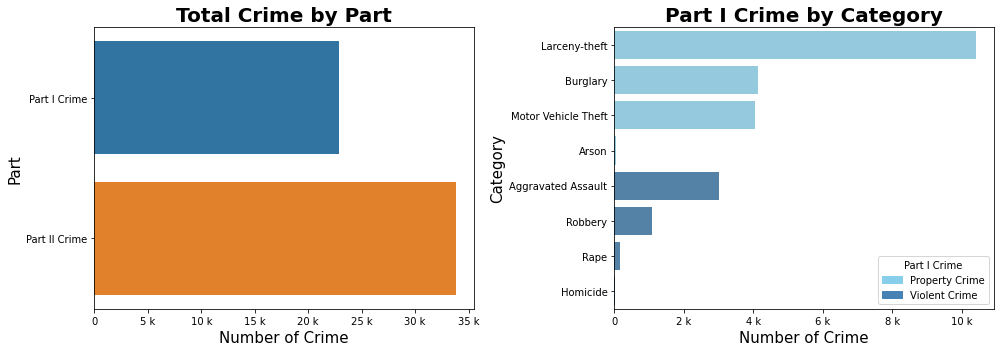

In [147]:
# Visualize the result
crime_pd_df1 = df_crime_part.toPandas()
crime_pd_df2 = df_category.toPandas()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,5))

ax1 = sns.barplot(y="part", x="count", data=crime_pd_df1, ax=ax1)
ax1.set_title('Total Crime by Part', fontsize=20, fontweight='bold')
ax1.set_xlabel('Number of Crime', fontsize=15)
ax1.set_ylabel('Part', fontsize=15)
ax1.xaxis.set_major_formatter(EngFormatter())

ax2 = sns.barplot(y="category", x="count", data=crime_pd_df2, palette=['skyblue'] * 4 + ['steelblue'] * 4, order=prop+vio, ax=ax2)
ax2.set_title('Part I Crime by Category', fontsize=20, fontweight='bold')
ax2.set_xlabel('Number of Crime', fontsize=15)
ax2.set_ylabel('Category', fontsize=15)
ax2.xaxis.set_major_formatter(EngFormatter())
# Set legend
prop_leg = mpatches.Patch(color='skyblue', label='Property Crime')
vio_leg = mpatches.Patch(color='steelblue', label='Violent Crime')
plt.legend(handles=[prop_leg, vio_leg], loc='lower right', title="Part I Crime")

fig.tight_layout()

plt.show()

Part II crimes are the more common than Part I crimes in San Diego County. In Part I crimes, the larceny-theft is the most common property crimes, and the aggravated assalut is the most common violent crimes.

### 2.2 Crime by Category and Time

In [250]:
# Count crime by year
df_year = df.select("year", "sub_part").groupBy(["year", "sub_part"]).count().orderBy(["year", "sub_part"], ascending=True)

# Count property crime by year
df_year_prop = df.select("year", "category").where(df.sub_part == "Property Crime").groupBy(["year", "category"]).count()
df_year_prop = df_year_prop.orderBy("count", ascending=False)

# Count violent crime by year
df_year_vio = df.select("year", "category").where(df.sub_part == "Violent Crime").groupBy(["year", "category"]).count().orderBy(["year", "category"], ascending=True)
df_year_vio = df_year_vio.orderBy("count", ascending=False)

In [251]:
# Count crime by month
df_month = df.groupBy(['year', 'month', "sub_part"]).count().orderBy(['month', "sub_part"], ascending=True)

# Count property crime by month
df_month_prop = df.select('year', 'month', 'category').where(df.sub_part == "Property Crime").groupBy(['year', 'month', 'category']).count()
df_month_prop = df_month_prop.orderBy(['month', 'count'], ascending=[1,0])

# Count violent crime by month
df_month_vio = df.select('year', 'month', "category").where(df.sub_part == "Violent Crime").groupBy(['year', 'month', "category"]).count()
df_month_vio = df_month_vio.orderBy(['month', 'count'], ascending=[1,0])

In [252]:
# Count crime by day of month
df_day = df.groupBy(['month', 'day', "sub_part"]).count().orderBy(['month', 'day'], ascending=True)

# Count property crime by day of month
df_day_prop = df.select('month', 'day', "category").where(df.sub_part == "Property Crime").groupBy(['month', 'day', "category"]).count()
df_day_prop = df_day_prop.orderBy(['day', 'count'], ascending=[1,0])

# Count violent crime by day of month
df_day_vio = df.select('month', 'day', "category").where(df.sub_part == "Violent Crime").groupBy(['month', 'day', "category"]).count()
df_day_vio = df_day_vio.orderBy(['day', 'count'], ascending=[1,0])

In [248]:
# Count crime by day of week
df_dayofweek = df.groupBy(['week', 'day_of_week', "sub_part"]).count().orderBy(['day_of_week', 'sub_part'], ascending=True)

# Count property crime by day of week
df_dayofweek_prop = df.select('week', 'day_of_week', "category").where(df.sub_part == "Property Crime").groupBy(['week', 'day_of_week', "category"]).count()
df_dayofweek_prop = df_dayofweek_prop.orderBy(['day_of_week', 'count'], ascending=[1,0])

# Count violent crime by day of week
df_dayofweek_vio = df.select('week', 'day_of_week', "category").where(df.sub_part == "Violent Crime").groupBy(['week', 'day_of_week', "category"]).count()
df_dayofweek_vio = df_dayofweek_vio.orderBy(['day_of_week', 'count'], ascending=[1,0])

In [249]:
# Count crime by hour of day
df_hourofday = df.groupBy(['day', 'hour', "sub_part"]).count().orderBy(['hour', 'sub_part'], ascending=True)

# Count property crime by hour of day
df_hourofday_prop = df.select('day', 'hour', "category").where(df.sub_part == "Property Crime").groupBy(['day', 'hour', "category"]).count()
df_hourofday_prop = df_hourofday_prop.orderBy(['hour', 'count'], ascending=[1,0])

# Count violent crime by hour of day
df_hourofday_vio = df.select('day', 'hour', "category").where(df.sub_part == "Violent Crime").groupBy(['day', 'hour', "category"]).count()
df_hourofday_vio = df_hourofday_vio.orderBy(['hour', 'count'], ascending=[1,0])

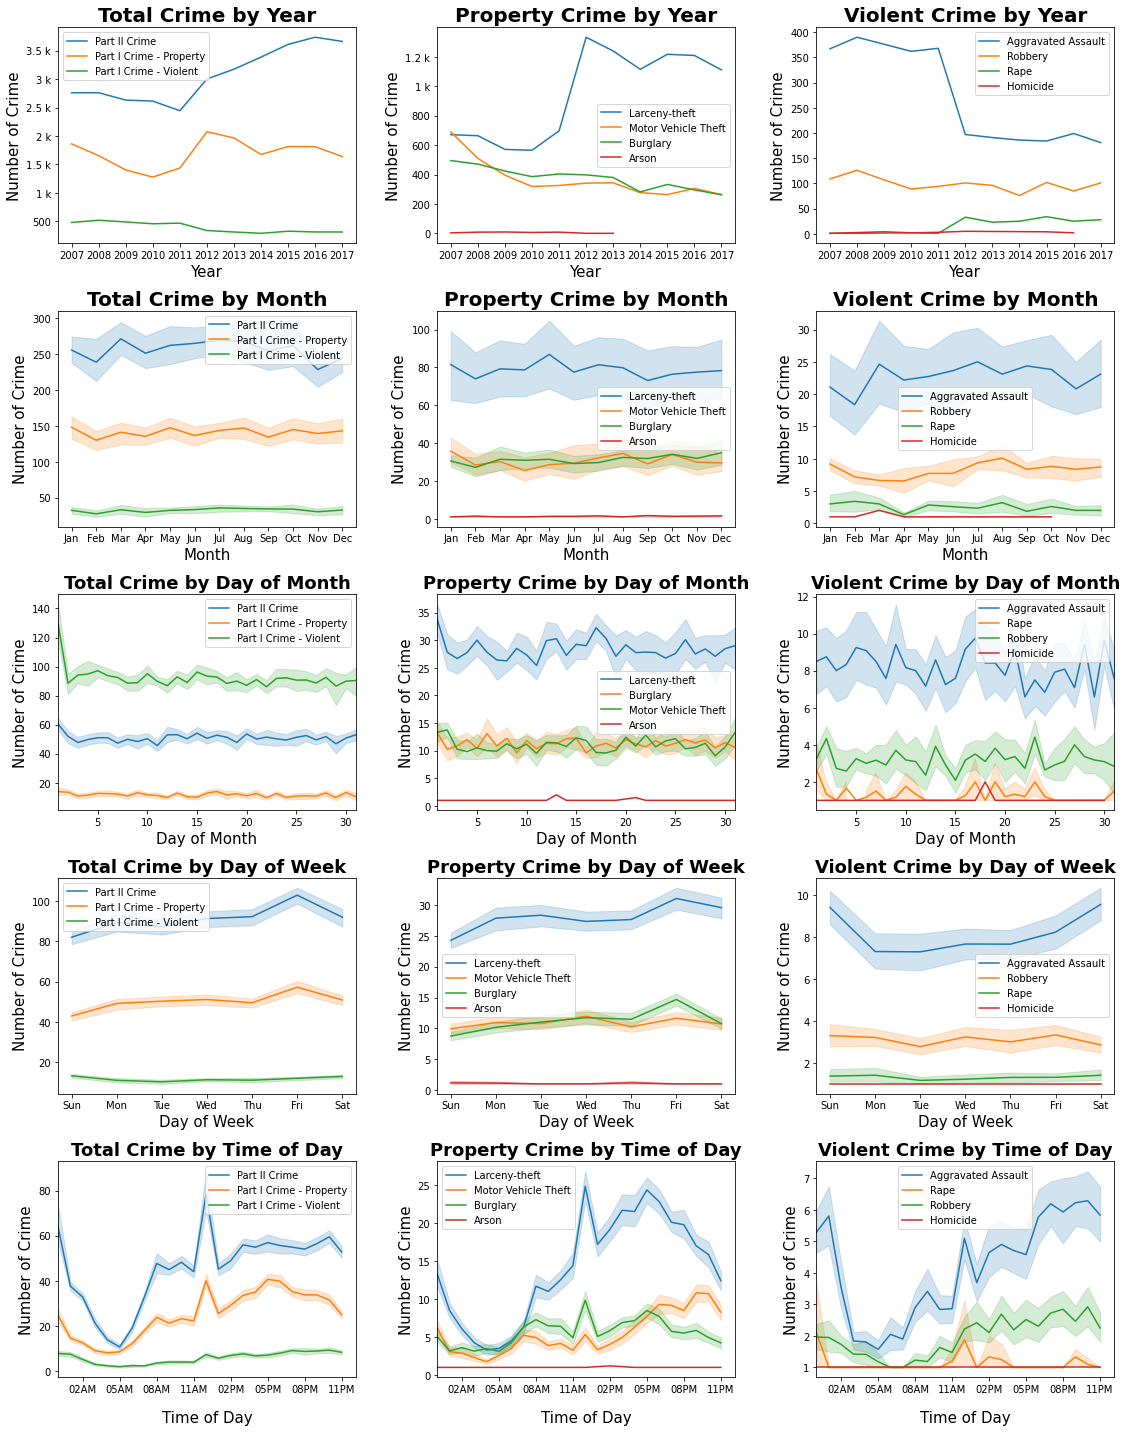

In [253]:
# Visualize the result
fig, ax = plt.subplots(5,3, figsize=(16,20))

# Plot crime by year
crime_pd_df00 = df_year.toPandas()
crime_pd_df01 = df_year_prop.toPandas()
crime_pd_df02 = df_year_vio.toPandas()

ax[0, 0] = sns.lineplot(x="year", y="count", data=crime_pd_df00, hue="sub_part", ax=ax[0, 0])
ax[0, 0].set_title('Total Crime by Year', fontsize=20, fontweight='bold')
ax[0, 0].set_xlabel('Year', fontsize=15)
ax[0, 0].set_ylabel('Number of Crime', fontsize=15)
ax[0, 0].xaxis.set_major_locator(MultipleLocator(1)) # Set x axis interval
ax[0, 0].yaxis.set_major_formatter(EngFormatter())
# Set legend
ax[0, 0].legend(labels=['Part II Crime', 'Part I Crime - Property', "Part I Crime - Violent"])

ax[0, 1] = sns.lineplot(x="year", y="count", data=crime_pd_df01, hue="category", ax=ax[0, 1])
ax[0, 1].set_title('Property Crime by Year', fontsize=20, fontweight='bold')
ax[0, 1].set_xlabel('Year', fontsize=15)
ax[0, 1].set_ylabel('Number of Crime', fontsize=15)
ax[0, 1].xaxis.set_major_locator(MultipleLocator(1)) # Set x axis interval
ax[0, 1].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[0, 1].get_legend_handles_labels()
ax[0, 1].legend(labels=labels0[1:])

ax[0, 2] = sns.lineplot(x="year", y="count", data=crime_pd_df02, hue="category", ax=ax[0, 2])
ax[0, 2].set_title('Violent Crime by Year', fontsize=20, fontweight='bold')
ax[0, 2].set_xlabel('Year', fontsize=15)
ax[0, 2].set_ylabel('Number of Crime', fontsize=15)
ax[0, 2].xaxis.set_major_locator(MultipleLocator(1)) # Set x axis interval
ax[0, 2].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[0, 2].get_legend_handles_labels()
ax[0, 2].legend(labels=labels0[1:])


# Plot crime by month
crime_pd_df10 = df_month.toPandas()
crime_pd_df11 = df_month_prop.toPandas()
crime_pd_df12 = df_month_vio.toPandas()

crime_pd_df10['month'] = crime_pd_df10['month'].apply(lambda x: calendar.month_abbr[x])
crime_pd_df11['month'] = crime_pd_df11['month'].apply(lambda x: calendar.month_abbr[x])
crime_pd_df12['month'] = crime_pd_df12['month'].apply(lambda x: calendar.month_abbr[x])

ax[1, 0] = sns.lineplot(x="month", y="count", hue="sub_part", data=crime_pd_df10, sort=False, ax=ax[1, 0])
ax[1, 0].set_title('Total Crime by Month', fontsize=20, fontweight='bold')
ax[1, 0].set_xlabel('Month', fontsize=15)
ax[1, 0].set_ylabel('Number of Crime', fontsize=15)
ax[1, 0].xaxis.set_major_locator(MultipleLocator(1))
ax[1, 0].yaxis.set_major_formatter(EngFormatter())
ax[1, 0].legend(labels=['Part II Crime', 'Part I Crime - Property', "Part I Crime - Violent"])

ax[1, 1] = sns.lineplot(x="month", y="count", data=crime_pd_df11, hue="category", sort=False, ax=ax[1, 1])
ax[1, 1].set_title('Property Crime by Month', fontsize=20, fontweight='bold')
ax[1, 1].set_xlabel('Month', fontsize=15)
ax[1, 1].set_ylabel('Number of Crime', fontsize=15)
ax[1, 1].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[1, 1].get_legend_handles_labels()
ax[1, 1].legend(labels=labels0[1:])

ax[1, 2] = sns.lineplot(x="month", y="count", data=crime_pd_df12, hue="category", sort=False, ax=ax[1, 2])
ax[1, 2].set_title('Violent Crime by Month', fontsize=20, fontweight='bold')
ax[1, 2].set_xlabel('Month', fontsize=15)
ax[1, 2].set_ylabel('Number of Crime', fontsize=15)
ax[1, 2].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[1, 2].get_legend_handles_labels()
ax[1, 2].legend(labels=labels0[1:])


# Plot crime by day of month
crime_pd_df20 = df_day.toPandas()
crime_pd_df21 = df_day_prop.toPandas()
crime_pd_df22 = df_day_vio.toPandas()

ax[2, 0] = sns.lineplot(x="day", y="count", data=crime_pd_df20, hue="sub_part", ax=ax[2, 0])
ax[2, 0].set_title('Total Crime by Day of Month', fontsize=18, fontweight='bold')
ax[2, 0].set_xlabel('Day of Month', fontsize=15)
ax[2, 0].set_ylabel('Number of Crime', fontsize=15)
ax[2, 0].set_xlim(1, 31)
ax[2, 0].yaxis.set_major_formatter(EngFormatter())
ax[2, 0].legend(labels=['Part II Crime', 'Part I Crime - Property', "Part I Crime - Violent"])

ax[2, 1] = sns.lineplot(x="day", y="count", data=crime_pd_df21, hue="category", sort=False, ax=ax[2, 1])
ax[2, 1].set_title('Property Crime by Day of Month', fontsize=18, fontweight='bold')
ax[2, 1].set_xlabel('Day of Month', fontsize=15)
ax[2, 1].set_ylabel('Number of Crime', fontsize=15)
ax[2, 1].set_xlim(1, 31)
ax[2, 1].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[2, 1].get_legend_handles_labels()
ax[2, 1].legend(labels=labels0[1:])

ax[2, 2] = sns.lineplot(x="day", y="count", data=crime_pd_df22, hue="category", sort=False, ax=ax[2, 2])
ax[2, 2].set_title('Violent Crime by Day of Month', fontsize=18, fontweight='bold')
ax[2, 2].set_xlabel('Day of Month', fontsize=15)
ax[2, 2].set_ylabel('Number of Crime', fontsize=15)
ax[2, 2].set_xlim(1, 31)
ax[2, 2].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[2, 2].get_legend_handles_labels()
ax[2, 2].legend(labels=labels0[1:])


# Plot crime by day of week
crime_pd_df30 = df_dayofweek.toPandas()
crime_pd_df31 = df_dayofweek_prop.toPandas()
crime_pd_df32 = df_dayofweek_vio.toPandas()

crime_pd_df30['day_of_week'] = crime_pd_df30['day_of_week'].apply(lambda x: calendar.day_abbr[x - 2])
crime_pd_df31['day_of_week'] = crime_pd_df31['day_of_week'].apply(lambda x: calendar.day_abbr[x - 2])
crime_pd_df32['day_of_week'] = crime_pd_df32['day_of_week'].apply(lambda x: calendar.day_abbr[x - 2])

ax[3, 0] = sns.lineplot(x="day_of_week", y="count", data=crime_pd_df30, hue="sub_part", sort=False, ax=ax[3, 0])
ax[3, 0].set_title('Total Crime by Day of Week', fontsize=18, fontweight='bold')
ax[3, 0].set_xlabel('Day of Week', fontsize=15)
ax[3, 0].set_ylabel('Number of Crime', fontsize=15)
ax[3, 0].yaxis.set_major_formatter(EngFormatter())
ax[3, 0].legend(labels=['Part II Crime', 'Part I Crime - Property', "Part I Crime - Violent"])

ax[3, 1] = sns.lineplot(x="day_of_week", y="count", data=crime_pd_df31, hue="category", sort=False, ax=ax[3, 1])
ax[3, 1].set_title('Property Crime by Day of Week', fontsize=18, fontweight='bold')
ax[3, 1].set_xlabel('Day of Week', fontsize=15)
ax[3, 1].set_ylabel('Number of Crime', fontsize=15)
ax[3, 1].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[3, 1].get_legend_handles_labels()
ax[3, 1].legend(labels=labels0[1:])

ax[3, 2] = sns.lineplot(x="day_of_week", y="count", data=crime_pd_df32, hue="category", sort=False, ax=ax[3, 2])
ax[3, 2].set_title('Violent Crime by Day of Week', fontsize=18, fontweight='bold')
ax[3, 2].set_xlabel('Day of Week', fontsize=15)
ax[3, 2].set_ylabel('Number of Crime', fontsize=15)
ax[3, 2].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[3, 2].get_legend_handles_labels()
ax[3, 2].legend(labels=labels0[1:])


# Plot crime by time of day
crime_pd_df40 = df_hourofday.toPandas()
crime_pd_df41 = df_hourofday_prop.toPandas()
crime_pd_df42 = df_hourofday_vio.toPandas()

crime_pd_df40["hour"] = pd.to_datetime(crime_pd_df40["hour"],format='%H')
crime_pd_df41["hour"] = pd.to_datetime(crime_pd_df41["hour"],format='%H')
crime_pd_df42["hour"] = pd.to_datetime(crime_pd_df42["hour"],format='%H')

ax[4, 0] = sns.lineplot(x="hour", y="count", data=crime_pd_df40, hue="sub_part", ax=ax[4, 0])
ax[4, 0].set_title('Total Crime by Time of Day', fontsize=18, fontweight='bold')
ax[4, 0].set_xlabel('Time of Day', fontsize=15)
ax[4, 0].set_ylabel('Number of Crime', fontsize=15)
ax[4, 0].set_xlim(crime_pd_df40["hour"][0],)
ax[4, 0].xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%I%p\n'))
ax[4, 0].yaxis.set_major_formatter(EngFormatter())
ax[4, 0].legend(labels=['Part II Crime', 'Part I Crime - Property', "Part I Crime - Violent"])

ax[4, 1] = sns.lineplot(x="hour", y="count", data=crime_pd_df41, hue="category", sort=False, ax=ax[4, 1])
ax[4, 1].set_title('Property Crime by Time of Day', fontsize=18, fontweight='bold')
ax[4, 1].set_xlabel('Time of Day', fontsize=15)
ax[4, 1].set_ylabel('Number of Crime', fontsize=15)
ax[4, 1].set_xlim(crime_pd_df41["hour"][0],)
ax[4, 1].xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%I%p\n'))
ax[4, 1].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[4, 1].get_legend_handles_labels()
ax[4, 1].legend(labels=labels0[1:])

ax[4, 2] = sns.lineplot(x="hour", y="count", data=crime_pd_df42, hue="category", sort=False, ax=ax[4, 2])
ax[4, 2].set_title('Violent Crime by Time of Day', fontsize=18, fontweight='bold')
ax[4, 2].set_xlabel('Time of Day', fontsize=15)
ax[4, 2].set_ylabel('Number of Crime', fontsize=15)
ax[4, 2].set_xlim(crime_pd_df42["hour"][0],)
ax[4, 2].xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax[4, 2].xaxis.set_major_formatter(mdates.DateFormatter('%I%p\n'))
ax[4, 2].yaxis.set_major_formatter(EngFormatter())
# Remove ledgend title
handles0, labels0 = ax[4, 2].get_legend_handles_labels()
ax[4, 2].legend(labels=labels0[1:])

fig.tight_layout()

plt.show()

### 2.3 Crime by Category and Location

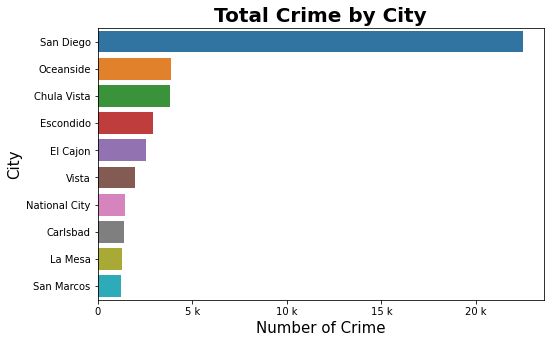

In [82]:
df_city = df.where(df.city_geo != "nan").groupBy('city_geo').count().orderBy('count', ascending=False).limit(10)

crime_pd_df = df_city.toPandas()

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.barplot(y="city_geo", x="count", data=crime_pd_df)
ax.set_title('Total Crime by City', fontsize=20, fontweight='bold')
ax.set_xlabel('Number of Crime', fontsize=15)
ax.set_ylabel('City', fontsize=15)
ax.xaxis.set_major_formatter(EngFormatter())

plt.show()

## 3: Geospatial Visualization

### 3.1 Heatmap of Crime

In [254]:
# Create heat map
df_geo['latitude'] = df_geo['latitude'].astype(float)
df_geo['longitude'] = df_geo['longitude'].astype(float)
heat_df = df_geo[['latitude', 'longitude']]

m = folium.Map(location=[32.937521, -117.033215], tiles='cartodbpositron', zoom_start=9.5)
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]
HeatMap(data=heat_data, radius=9).add_to(m)
m

## 4: Conclusion

* Analyzed the crime data of San Diego County for the past 11 years (2007 to 2017) and provided insights.
* Conducted Spark SQL and Spark DataFrames for data processing and data visulization on more than 2 million data points.
* Created heat map using folium to visulize the crime on map.

